# Interresolution figure

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.path as mpath
import xarray as xr
import cf_xarray
import cmocean as cm

In [2]:
# Import the data (names generalised to use for both comparisons)

data_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_Pan01.nc', chunks = 'auto')
data_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_Pan005.nc', chunks = 'auto')

In [4]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [5]:
# Land and contour data
depth_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask_1 = (0 * depth_1).fillna(1)
land_1 = xr.where(np.isnan(depth_1.rename('land_1')), 1, np.nan)
depth_1_shelf, shelf_contour_1 = shelf_mask_isobath(depth_1, 'mom6_01')

depth_2 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['deptho']
land_mask_2 = (0 * depth_2).fillna(1)
land_2 = xr.where(np.isnan(depth_2.rename('land_2')), 1, np.nan)
depth_2_shelf, shelf_contour_2 = shelf_mask_isobath(depth_2, 'mom6_005')

In [50]:
shelf_contour_plot_1 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']
shelf_contour_plot_2 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc')['contour_masked_above']

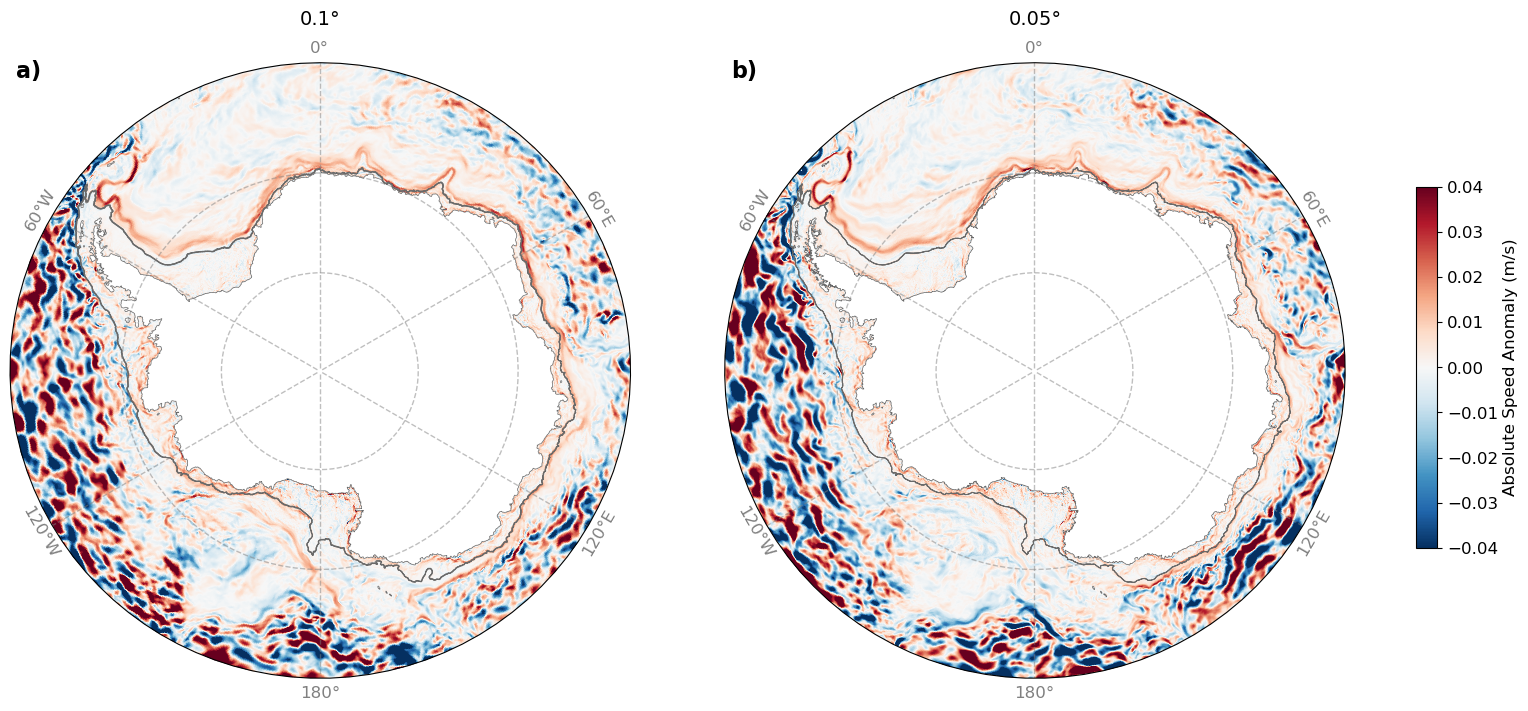

In [4]:
plt.rcParams['font.size'] = 16

# Projection
projection = ccrs.SouthPolarStereo()

# Figure with 2 subplots side by side
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    subplot_kw={"projection": projection},
    figsize=(16, 7),
    constrained_layout=True
)

# Shared circle boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Datasets, land masks, shelf masks, and titles
datasets = [data_1, data_2] 
land_masks = [land_1, land_2]
land_contours = [land_mask_1, land_mask_2]
shelf_masks = [shelf_contour_1, shelf_contour_2]
titles = ["0.1°", "0.05°"]

# Longitude label settings for rotation
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60]
lat_lon_label = [-58, -58, -58, -58, -58, -58]

# Loop over subplots
for i, (ax, data, land_m, land_contour, shelf_m, title) in enumerate(zip(
        axes, datasets, land_masks, land_contours, shelf_masks, titles)):

    ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

    # Filled land
    land_m.plot.contourf(ax=ax, colors='white',
                         zorder=2, transform=ccrs.PlateCarree(),
                         add_colorbar=False)

    # Coast line
    ax.contour(land_contour.cf['X'], land_contour.cf['Y'], land_contour,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Shelf contour
    ax.contour(shelf_m.cf['X'], shelf_m.cf['Y'], shelf_m,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Gridlines (keep as in original plot)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, xlocs=range(-180, 171, 60), ylocs=[],
                      color='gray', alpha=0.5, linestyle='--', zorder=10)
    gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, xlocs=[], ylocs=(-80, -70, -55),
                       color='gray', alpha=0.5, linestyle='--', zorder=10)

    # Manually rotate longitude labels
    for j, position in enumerate([0, 180, 60, -120, 120, -60]):
        ax.text(position, lat_lon_label[j], label_lon[j], rotation=rot_lon[j],
                ha='center', va='center', color='gray', fontsize=12,
                transform=ccrs.PlateCarree())

    # Plot dataset
    im = data.plot(
        x="xh", y="yh",
        transform=ccrs.PlateCarree(),
        vmin=-0.04, vmax=0.04,
        extend="both",
        cmap=plt.get_cmap('RdBu').reversed(),
        add_colorbar=False,
        ax=ax,
    )

    # Set title
    ax.set_title(title, fontsize=14, pad=25)

    # Add subplot label (a), (b), etc.
    ax.text(0.01,1, f'{chr(97+i)})', transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left', color='black')


# Smaller shared colorbar on the right
cbar = fig.colorbar(
    im, ax=axes, orientation="vertical",
    fraction=0.015,  # smaller width
    aspect=17,       # longer and thinner
    shrink=0.8, pad=0.05
)
cbar.set_label("Absolute Speed Anomaly (m/s)", fontsize=12)
cbar.ax.tick_params(labelsize=12)  # tick font size

plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/resolution_surfacevelocity_maps.png", dpi=300, bbox_inches='tight')

# West Antarctic ACoC plot

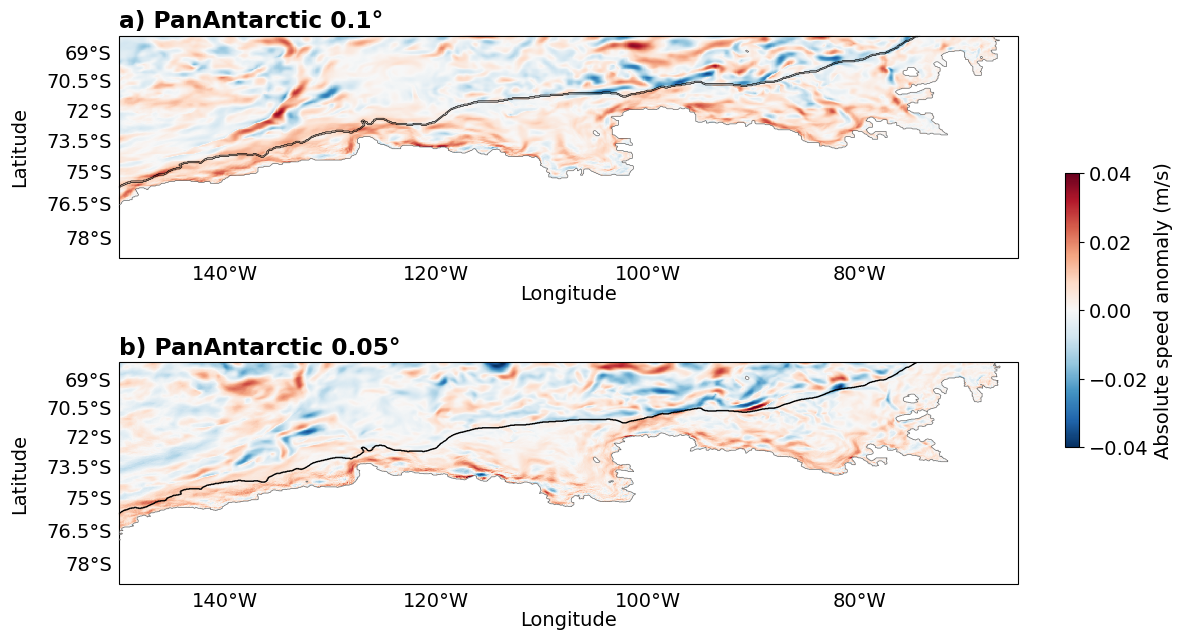

In [ ]:
# --- Define region of interest (West Antarctic shelf) ---
lon_min, lon_max = -150, -65
lat_min, lat_max = -75, -68

# --- Group datasets ---
datasets = [
    {
        "data": data_1,
        "land": land_1,
        "shelf_contour": shelf_contour_1,
        "land_mask": land_mask_1,
        "title": "a) PanAntarctic 0.1°"
    },
    {
        "data": data_2,
        "land": land_2,
        "shelf_contour": shelf_contour_2,
        "land_mask": land_mask_2,
        "title": "b) PanAntarctic 0.05°"
    }
]

# --- Figure and layout setup ---
plt.rcParams['font.size'] = 14
n = len(datasets)

fig = plt.figure(figsize=(13.5, 6.3),constrained_layout=True) 
gs = fig.add_gridspec(n, 1, height_ratios=[1,1], hspace=0.1)  

axes = [fig.add_subplot(gs[i, 0], projection=ccrs.Miller()) for i in range(n)]

# --- Plot setup ---
vmin, vmax = -0.04, 0.04
cmap = plt.get_cmap('RdBu').reversed()
mappables = []

for ax, dset in zip(axes, datasets):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.set_title(dset["title"], loc='left',fontweight='bold')

    # Main field
    mappable = dset["data"].plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False
    )
    mappables.append(mappable)

    # Filled land
    dset["land"].plot.contourf(
        ax=ax, colors='white',
        transform=ccrs.PlateCarree(), add_colorbar=False
    )

    # 1000 m isobath
    dset["shelf_contour"].plot.contour(
        ax=ax, levels=[1], colors='k', linewidths=.5,
        transform=ccrs.PlateCarree()
    )

    # Coastline
    ax.contour(
        dset["land_mask"].cf['X'], dset["land_mask"].cf['Y'], dset["land_mask"],
        levels=[0, 1], colors='dimgrey', linewidths=0.5,zorder=4,
        transform=ccrs.PlateCarree()
    )

    # Minimal labels/gridlines
    gl = ax.gridlines(draw_labels=True,alpha=0)
    gl.top_labels = gl.right_labels = False


for i, ax in enumerate(axes):
    if i == 0:  # left plot
        ax.text(0.5, -0.12, 'Longitude', va='top', ha='center',
                transform=ax.transAxes)
        ax.text(-0.1, 0.5, 'Latitude', va='center', ha='right',
                rotation='vertical', transform=ax.transAxes)
    if i == len(axes)-1:  # bottom plot
        ax.text(0.5, -0.12, 'Longitude', va='top', ha='center',
                transform=ax.transAxes)
        ax.text(-0.1, 0.5, 'Latitude', va='center', ha='right',
                rotation='vertical', transform=ax.transAxes)

# --- Shared colorbar ---
cbar = fig.colorbar(
    mappables[0], ax=axes, orientation='vertical',shrink=0.5,
    fraction=0.1, pad=0.04
)
cbar.set_label("Absolute speed anomaly (m/s)")

plt.show()
fig.savefig("/g/data/g40/kc5856/thesis_figures/resolution_acoc_maps.png", dpi=300, bbox_inches='tight')

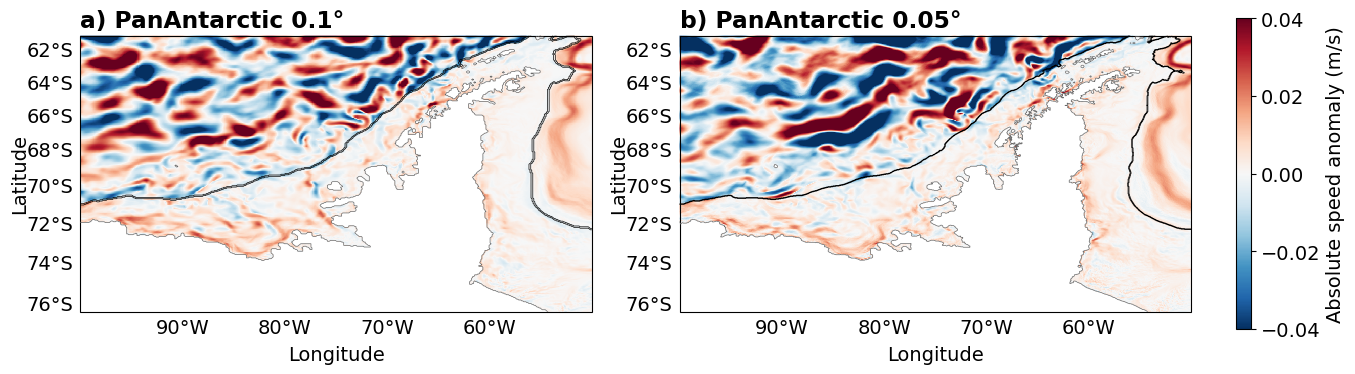

In [60]:
# --- Define region of interest (West Antarctic shelf) ---
lon_min, lon_max = -100, -50
lat_min, lat_max = -75, -61

# --- Group datasets ---
datasets = [
    {
        "data": data_1,
        "land": land_1,
        "shelf_contour": shelf_contour_plot_1,
        "land_mask": land_mask_1,
        "title": "a) PanAntarctic 0.1°"
    },
    {
        "data": data_2,
        "land": land_2,
        "shelf_contour": shelf_contour_plot_2,
        "land_mask": land_mask_2,
        "title": "b) PanAntarctic 0.05°"
    }
]

# --- Figure and layout setup ---
plt.rcParams['font.size'] = 14
n = len(datasets)

fig = plt.figure(figsize=(13.5, 6.3),constrained_layout=True) 
gs = fig.add_gridspec(1, n)  

axes = [fig.add_subplot(gs[0, i], projection=ccrs.Miller()) for i in range(n)]

# --- Plot setup ---
vmin, vmax = -0.04, 0.04
cmap = plt.get_cmap('RdBu').reversed()
mappables = []

for ax, dset in zip(axes, datasets):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.set_title(dset["title"], loc='left',fontweight='bold')

    # Main field
    mappable = dset["data"].plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False
    )
    mappables.append(mappable)

    # Filled land
    dset["land"].plot.contourf(
        ax=ax, colors='white',
        transform=ccrs.PlateCarree(), add_colorbar=False
    )

    # 1000 m isobath
    dset["shelf_contour"].plot.contour(
        ax=ax, levels=[1], colors='k', linewidths=.5,
        transform=ccrs.PlateCarree()
    )

    # Coastline
    ax.contour(
        dset["land_mask"].cf['X'], dset["land_mask"].cf['Y'], dset["land_mask"],
        levels=[0, 1], colors='dimgrey', linewidths=0.5,zorder=4,
        transform=ccrs.PlateCarree()
    )

    # Minimal labels/gridlines
    gl = ax.gridlines(draw_labels=True,alpha=0)
    gl.top_labels = gl.right_labels = False


for i, ax in enumerate(axes):
    if i == 0:  # left plot
        ax.text(0.5, -0.12, 'Longitude', va='top', ha='center',
                transform=ax.transAxes)
        ax.text(-0.1, 0.5, 'Latitude', va='center', ha='right',
                rotation='vertical', transform=ax.transAxes)
    if i == 1:  # bottom plot
        ax.text(0.5, -0.12, 'Longitude', va='top', ha='center',
                transform=ax.transAxes)
        ax.text(-0.1, 0.5, 'Latitude', va='center', ha='right',
                rotation='vertical', transform=ax.transAxes)

# --- Shared colorbar ---
cbar = fig.colorbar(
    mappables[0], ax=axes, orientation='vertical',shrink=0.5,
    fraction=0.1, pad=0.04
)
cbar.set_label("Absolute speed anomaly (m/s)")

plt.show()
fig.savefig("/g/data/g40/kc5856/thesis_figures/resolution_acoc_maps_longer.png", dpi=300, bbox_inches='tight')

# Quantifying ACoC

In [31]:
data_1_acoc = data_1.sel(xh=slice(-150,-65)).sel(yh=slice(-80,-68)).where(shelf_contour_1 == 1)
data_2_acoc = data_2.sel(xh=slice(-150,-65)).sel(yh=slice(-80,-68)).where(shelf_contour_2 == 1)

In [40]:
data_1_C = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_control_Pan01.nc')
data_2_C = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_control_Pan005.nc')
data_1_M = data_1 + data_1_C
data_2_M = data_2 + data_2_C

In [44]:
data_1_C_acoc = data_1_C.sel(xh=slice(-150,-65)).sel(yh=slice(-80,-68)).where(shelf_contour_1 == 1)
data_1_M_acoc = data_1_M.sel(xh=slice(-150,-65)).sel(yh=slice(-80,-68)).where(shelf_contour_1 == 1)
data_2_C_acoc = data_2_C.sel(xh=slice(-150,-65)).sel(yh=slice(-80,-68)).where(shelf_contour_2 == 1)
data_2_M_acoc = data_2_M.sel(xh=slice(-150,-65)).sel(yh=slice(-80,-68)).where(shelf_contour_2 == 1)

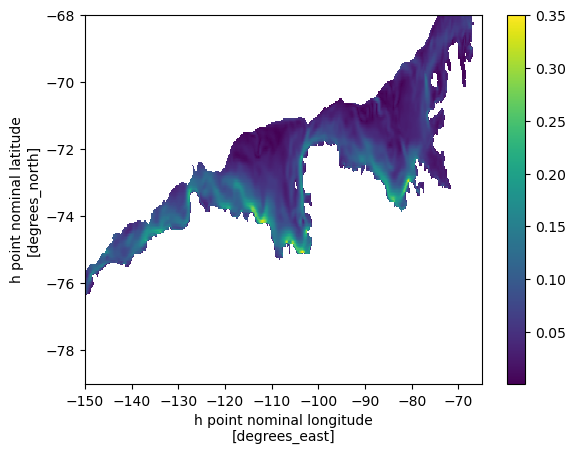

In [42]:
data_1_C_acoc.plot()

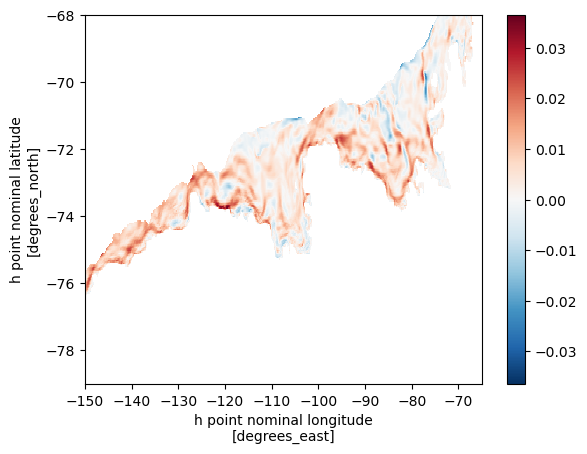

In [8]:
data_1_acoc.plot()

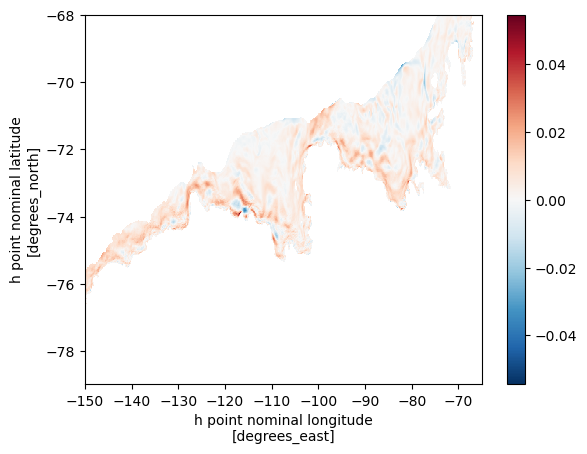

In [32]:
data_2_acoc.plot()

In [34]:
# Areas for averaging
area_old_01 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
area_old_005 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['areacello']
var_01 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_month_z.nc')['so']
var_005 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_month_z.nc')['so']
area_corr_01 = area_old_01*(var_01.isel(time=0,z_l=0)*0 +1)
area_corr_005 = area_old_005*(var_005.isel(time=0,z_l=0)*0 +1)

/jobfs/153246027.gadi-pbs/ipykernel_1208921/2630492097.py:4: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  var_01 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_month_z.nc')['so']
/jobfs/153246027.gadi-pbs/ipykernel_1208921/2630492097.py:5: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will

In [35]:
area_WA_01 = area_corr_01.sel(xh=slice(-150,-65)).sel(yh=slice(-80,-68)).where(shelf_contour_1 == 1)
area_WA_005 = area_corr_005.sel(xh=slice(-150,-65)).sel(yh=slice(-80,-68)).where(shelf_contour_2 == 1)

In [45]:
# Spatial averages
data_1_acoc_ave = (area_corr_01 * data_1_acoc).sum(['xh', 'yh']) / area_WA_01.sum(['xh', 'yh'])
data_2_acoc_ave = (area_corr_005 * data_2_acoc).sum(['xh', 'yh']) / area_WA_005.sum(['xh', 'yh'])

# For all experiments
data_1_C_acoc_ave = (area_corr_01 * data_1_C_acoc).sum(['xh', 'yh']) / area_WA_01.sum(['xh', 'yh'])
data_1_M_acoc_ave = (area_corr_01 * data_1_M_acoc).sum(['xh', 'yh']) / area_WA_01.sum(['xh', 'yh'])
data_2_C_acoc_ave = (area_corr_005 * data_2_C_acoc).sum(['xh', 'yh']) / area_WA_005.sum(['xh', 'yh'])
data_2_M_acoc_ave = (area_corr_005 * data_2_M_acoc).sum(['xh', 'yh']) / area_WA_005.sum(['xh', 'yh'])

In [47]:
(data_1_M_acoc_ave/data_1_C_acoc_ave).load()

<xarray.DataArray ()> Size: 4B
array(1.0601913, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [48]:
(data_2_M_acoc_ave/data_2_C_acoc_ave).load()

<xarray.DataArray ()> Size: 4B
array(1.0499443, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2010-12-16 12:00:00

# Making my own 3000m isobath contour

In [44]:
anomaly_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_Pan01.nc')
control_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_control_Pan01.nc')

In [45]:
anomaly_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_Pan005.nc')
control_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_control_Pan005.nc')

In [88]:
contour_depth = 2500 # metres

Text(0.5, 1.0, 'Ocean depth (m)')

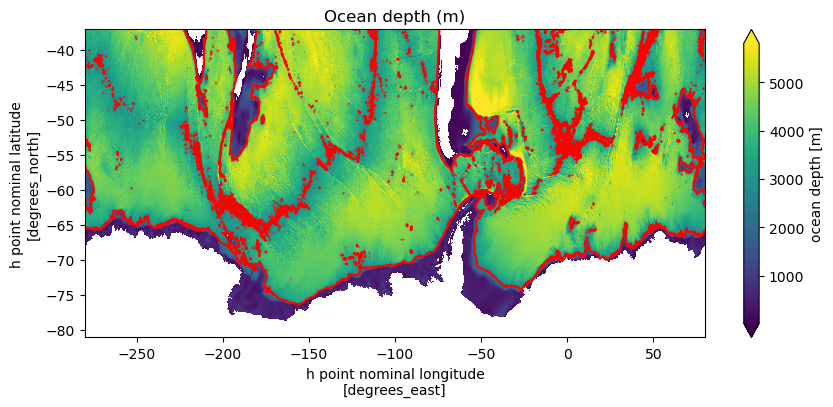

In [89]:
fig = plt.figure(figsize = (10, 4))

depth_2.plot(extend='both', cbar_kwargs={'label': "ocean depth [m]"})
depth_2.plot.contour(levels = [contour_depth], colors = 'r', linestyles = '-')
plt.title('Ocean depth (m)')

In [90]:
depth_2_edit = depth_2.fillna(0).load()

In [91]:
grid_sel = 't'
x_var = depth_2_edit['xh']
y_var = depth_2_edit['yh']

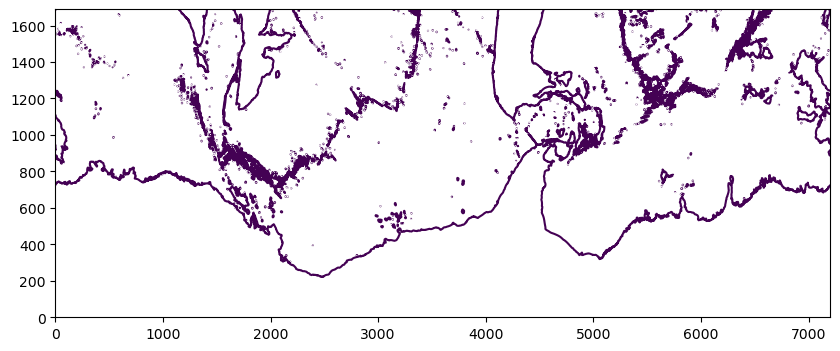

In [92]:
fig = plt.figure(figsize = (10, 4))
sc = plt.contour(depth_2_edit, levels=[contour_depth])

path_vertices = (sc.get_paths()[0]).vertices
x_vertices = path_vertices[:, 0]
y_vertices = path_vertices[:, 1]

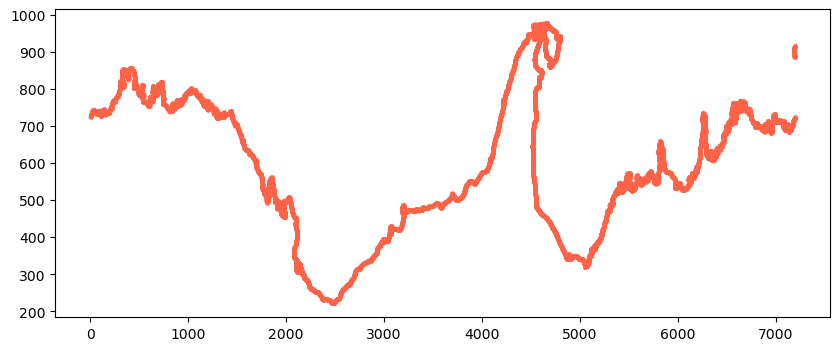

In [93]:
last_contour_index = np.where(np.abs(np.diff(x_vertices).astype(int)) > 1)[0][0]

x_contour = x_vertices[:last_contour_index + 1]
y_contour = y_vertices[:last_contour_index + 1]

# Check desired contour looks right:
fig = plt.figure(figsize = (10, 4))
plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

In [94]:
x_contour = np.round(x_contour).astype(int)
y_contour = np.round(y_contour).astype(int)

# check that the difference between coords of contour never increase by more than 1:
if np.max(np.abs(np.diff(x_contour))) != 1:
    print('help! x_contour increases by more than 1 between coords.')

if np.max(np.abs(np.diff(y_contour))) != 1:
    print('help! y_contour increases by more than 1 between coords.')

help! y_contour increases by more than 1 between coords.


In [95]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [96]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    x_contour = np.delete(x_contour, index)
    y_contour = np.delete(y_contour, index)

In [97]:
depth_2_edit_contour = np.zeros(len(x_contour))

for ii in range(len(depth_2_edit_contour)):
    depth_2_edit_contour[ii] = depth_2_edit[y_contour[ii], x_contour[ii]]

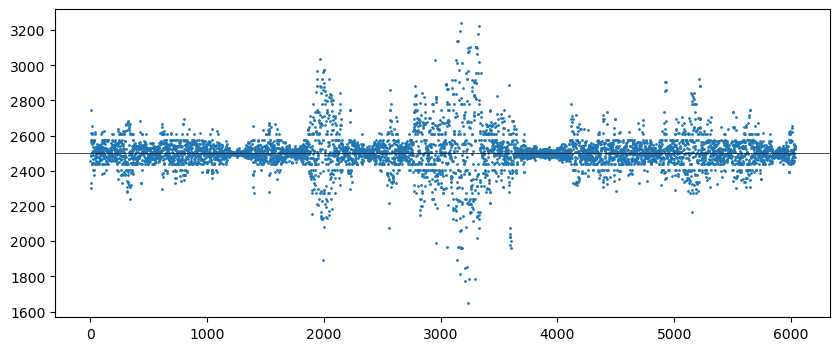

In [98]:
fig = plt.figure(figsize=(10, 4))

plt.plot(depth_1_edit_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

In [99]:
# Number of grid points on the contour
num_points = len(x_contour)
num_points

13470

In [100]:
# start numbering from 1 not 0:
contour_mask_numbered = np.arange(1, len(x_contour)+1)

In [101]:
contour_mask = xr.zeros_like(depth_2_edit)

for ii in range(num_points):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]

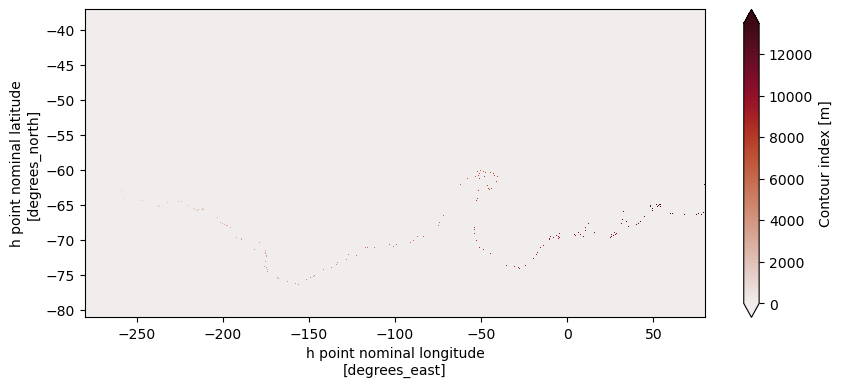

In [102]:
contour_mask.attrs['long_name'] = 'Contour index'
plt.figure(1, figsize=(10, 4))
contour_mask.plot(extend='both', cmap = cm.cm.amp);

In [103]:
contour_mask

<xarray.DataArray 'deptho' (yh: 1690, xh: 7200)> Size: 49MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 14kB -81.1 -81.08 -81.06 ... -37.16 -37.12 -37.08
Attributes:
    units:          m
    long_name:      Contour index
    cell_methods:   area:mean yh:mean xh:mean time: point
    cell_measures:  area: areacello
    standard_name:  sea_floor_depth_below_geoid

In [104]:
%%time

mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask.xh)-1):
    for jj in range(len(contour_mask.yh))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

#from top right:
for ii in range(len(contour_mask.xh))[::-1][:-1]:
    for jj in range(len(contour_mask.yh))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask.xh))[::-1][:-1]:
    for jj in range(len(contour_mask.yh)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask.xh)-1):
    for jj in range(len(contour_mask.yh)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

CPU times: user 3min 14s, sys: 60.8 ms, total: 3min 14s
Wall time: 3min 14s


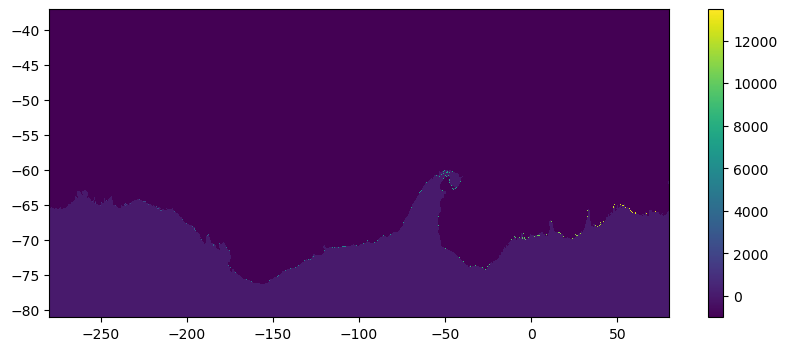

In [105]:
plt.figure(1, figsize=(10, 4))

plt.pcolormesh(contour_mask.xh, contour_mask.yh, contour_masked_above)
plt.colorbar()

In [106]:
contour_masked_above_da = xr.DataArray(
    contour_masked_above,
    dims=("yh", "xh"),
    coords={"yh": contour_mask.yh, "xh": contour_mask.xh},
    name="contour_masked_above"
)

In [107]:
contour_masked_above_da

<xarray.DataArray 'contour_masked_above' (yh: 1690, xh: 7200)> Size: 49MB
array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
       [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
       [-1000., -1000., -1000., ..., -1000., -1000., -1000.]],
      dtype=float32)
Coordinates:
  * yh       (yh) float64 14kB -81.1 -81.08 -81.06 ... -37.16 -37.12 -37.08
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97

In [108]:
contour_masked_above_da.to_netcdf('/g/data/g40/kc5856/panant-005-2500m-isobath-contour_masked_above.nc')

In [87]:
contour_masked_above_da.to_netcdf('/g/data/g40/kc5856/panant-01-2500m-isobath-contour_masked_above.nc')

In [66]:
contour_masked_above_da.to_netcdf('/g/data/g40/kc5856/panant-01-2000m-isobath-contour_masked_above.nc')

In [46]:
contour_mask.to_netcdf('/g/data/g40/kc5856/panant-005-2000m-isobath-mask.nc')

In [28]:
contour_mask.to_netcdf('/g/data/g40/kc5856/panant-01-2000m-isobath-mask.nc')